## Authors:
Christian Altrichter and Jury Andrea D'Onofrio

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


import sklearn.cluster as skl_cluster


In [3]:
sales = pd.read_csv("nyc-rolling-sales.csv")

# REMOVE INDEX
sales = sales.iloc[:, 1:]


# Pre-Processing Data

Count the number of unique values per column

In [4]:
list_of_columns = sales.columns
for i in list_of_columns:
    print(i, " unique vale = ", sales[i].nunique())


BOROUGH  unique vale =  5
NEIGHBORHOOD  unique vale =  254
BUILDING CLASS CATEGORY  unique vale =  47
TAX CLASS AT PRESENT  unique vale =  11
BLOCK  unique vale =  11566
LOT  unique vale =  2627
EASE-MENT  unique vale =  1
BUILDING CLASS AT PRESENT  unique vale =  167
ADDRESS  unique vale =  67563
APARTMENT NUMBER  unique vale =  3989
ZIP CODE  unique vale =  186
RESIDENTIAL UNITS  unique vale =  176
COMMERCIAL UNITS  unique vale =  55
TOTAL UNITS  unique vale =  192
LAND SQUARE FEET  unique vale =  6062
GROSS SQUARE FEET  unique vale =  5691
YEAR BUILT  unique vale =  158
TAX CLASS AT TIME OF SALE  unique vale =  4
BUILDING CLASS AT TIME OF SALE  unique vale =  166
SALE PRICE  unique vale =  10008
SALE DATE  unique vale =  364


Delete irrelevant columns (as outlined in the report - Section 3: Data Pre-Processing)

In [5]:
dropping_list = ['EASE-MENT', 'APARTMENT NUMBER', 'TAX CLASS AT PRESENT',
                 'BUILDING CLASS AT PRESENT', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS']
sales = sales.drop(columns=dropping_list, axis=1)


Modify columns (as outline in the report - Section 3: Data Pre-Processing)

In [6]:
sales["BUILDING CLASS AT TIME OF SALE"] = sales["BUILDING CLASS AT TIME OF SALE"].apply(
    lambda x: x[0])


Filter out rows with irrelevant data and transform data into integer values (as outlined in the report - Section 3: Data Pre-Processing)

In [7]:
sales = sales[sales["GROSS SQUARE FEET"] != "0"]
sales = sales[sales["GROSS SQUARE FEET"] != " -  "]
sales = sales[sales["LAND SQUARE FEET"] != "0"]
sales = sales[sales["LAND SQUARE FEET"] != " -  "]
sales = sales[sales["SALE PRICE"] != "0"]
sales = sales[sales["SALE PRICE"] != " -  "]


Create feature vectors (as outlined in the report - Section 3: Data Pre-Processing)

In [8]:
# Transform columns to integers
to_int = ["SALE PRICE", "GROSS SQUARE FEET", "LAND SQUARE FEET",
          "YEAR BUILT", "TAX CLASS AT TIME OF SALE"]

for elem in to_int:
    sales[elem] = sales[elem].astype('int')


# Factorize non-integer features to integer features
to_factorise = ["NEIGHBORHOOD", "BUILDING CLASS CATEGORY",
                "ADDRESS", "SALE DATE", "BUILDING CLASS AT TIME OF SALE"]

for elem in to_factorise:
    sales_fact = sales.loc[:, sales.columns ==
                           elem].apply(lambda x: x.factorize()[0])
    sales[elem] = sales_fact

# Filter out irrelevant sales prices that do not match the markets true transactions (prelimiary filtering)
sales = sales[sales["SALE PRICE"] > 50000]


Add columns for better understanding of the data

In [9]:
sales['SALE PRICE PER GROSS SQF'] = sales["SALE PRICE"] / \
    sales["GROSS SQUARE FEET"]


In [10]:
# Avg. Sales prices per borough in New York accoring to official Real Estate Market reports

manhattan = 1230
bronx = 309
brooklyn = 885
queens = 1020
state_island = 377

# remove all the entries from sales with values between +- 75%
manhattan_sales = sales[(sales["SALE PRICE PER GROSS SQF"] > manhattan-((manhattan*75)/100)) & (
    sales["SALE PRICE PER GROSS SQF"] < manhattan+((manhattan*75)/100)) & (sales["BOROUGH"] == 1)]

bronx_sales = sales[(sales["SALE PRICE PER GROSS SQF"] > bronx-((bronx*75)/100)) & (
    sales["SALE PRICE PER GROSS SQF"] < bronx+((bronx*75)/100)) & (sales["BOROUGH"] == 2)]

brooklyn_sales = sales[(sales["SALE PRICE PER GROSS SQF"] > brooklyn-((brooklyn*75)/100)) & (
    sales["SALE PRICE PER GROSS SQF"] < brooklyn+((brooklyn*75)/100)) & (sales["BOROUGH"] == 3)]

queens_sales = sales[(sales["SALE PRICE PER GROSS SQF"] > queens-((queens*75)/100)) & (
    sales["SALE PRICE PER GROSS SQF"] < queens+((queens*75)/100)) & (sales["BOROUGH"] == 4)]

state_island_sales = sales[(sales["SALE PRICE PER GROSS SQF"] > state_island-((state_island*75)/100)) & (
    sales["SALE PRICE PER GROSS SQF"] < state_island+((state_island*75)/100)) & (sales["BOROUGH"] == 5)]

sales = pd.concat([manhattan_sales, bronx_sales,
                  brooklyn_sales, queens_sales, state_island_sales])


# Visualization

Correlation matrix

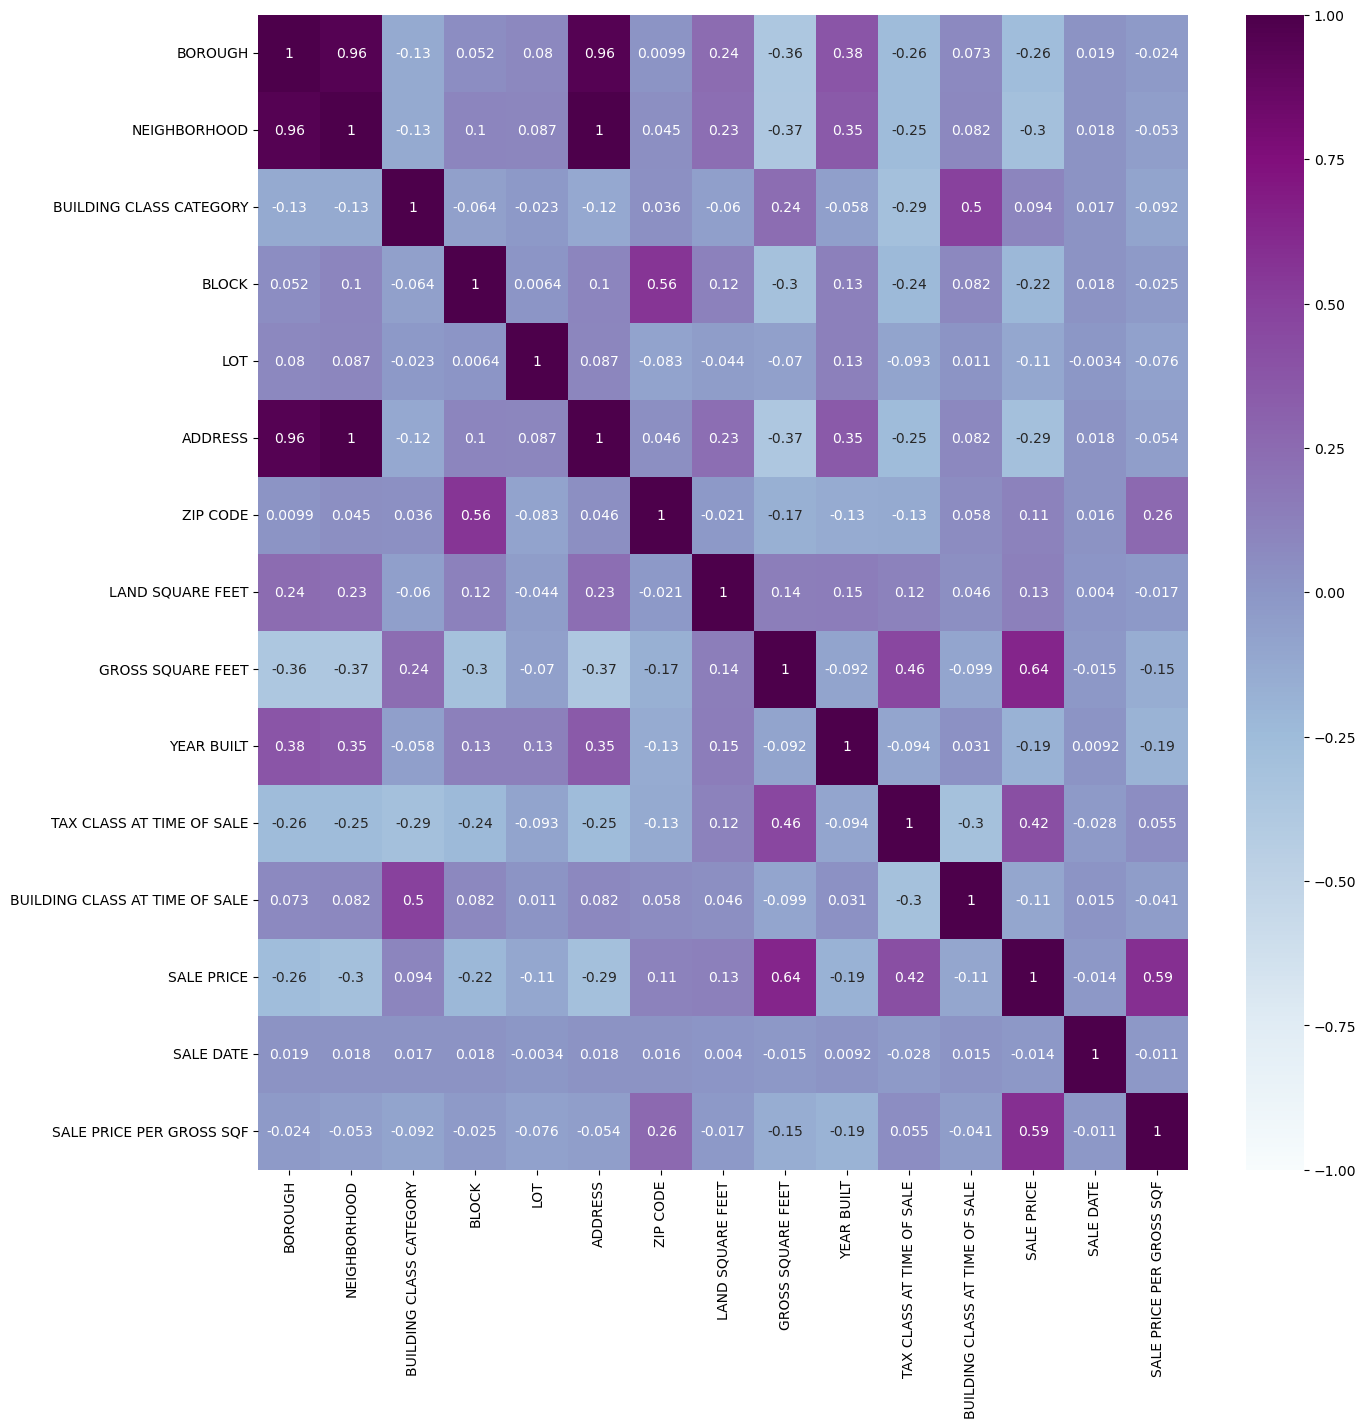

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(sales.corr('spearman'), vmin=-1,
            vmax=1, cmap="BuPu", annot=True, ax=ax)

plt.show()


In [12]:
# Remove all columns where spearman correlation is less than 0.25

dropping_list = []
cleaned_sales = sales.copy()

for column in sales:
    corr = sales["SALE PRICE"].corr(sales[column], method="spearman")
    corr = round(corr, 2)

    corr_2 = sales["SALE PRICE PER GROSS SQF"].corr(
        sales[column], method="spearman")
    corr_2 = round(corr_2, 2)

    if np.abs(corr) < 0.25 and np.abs(corr_2) < 0.25:
        dropping_list.append(column)

cleaned_sales = sales.drop(columns=dropping_list, axis=1)


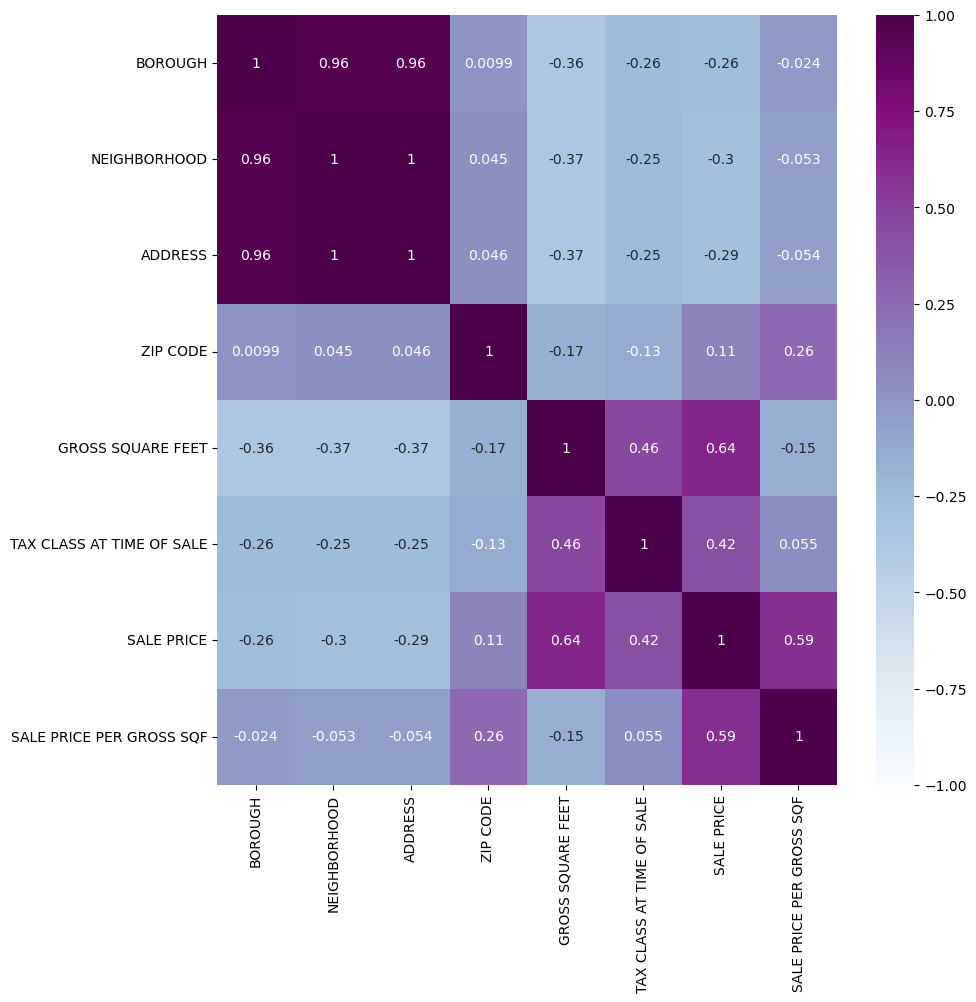

In [13]:
# New correlation matrix with reduced (weak) features
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cleaned_sales.corr('spearman'), vmin=-1,
            vmax=1, cmap="BuPu", annot=True, ax=ax)

plt.show()


Save modified data frame for future clustering

In [14]:
filepath = Path('csv_files/sales.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
cleaned_sales.to_csv(filepath, index=False)


## CLUSTERING ALGORITHM 1 - KMeans & Agglomerative

In [15]:
def cluster_algo(data, k_range=range(2, 50)):
    sil_score_k_means = []
    sil_score_agglom = []
    k_values = []

    labels_k_means = []
    labels_agglom = []

    for i in k_range:
        # To monitor progress
        # print("i is", i)
        # K-Means
        kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto')
        kmeans.fit(data.values)
        labels = kmeans.labels_
        labels_k_means.append([i, labels])
        score = silhouette_score(data, labels)
        sil_score_k_means.append(score)

        # Agglomerative
        hierarichal = AgglomerativeClustering(n_clusters=i)
        hierarichal.fit(data.values)
        labels2 = hierarichal.labels_
        labels_agglom.append([i, labels2])
        score2 = silhouette_score(data, labels2)
        sil_score_agglom.append(score2)

        k_values.append(i)

    df = pd.DataFrame({"K": k_values, "Silhouette score k - means": sil_score_k_means,
                      "Silhouette score agglomerate": sil_score_agglom})

    df.plot(x='K', y="Silhouette score k - means",
            kind='scatter', ylim=(-1, 1))
    plt.show()

    df.plot(x='K', y="Silhouette score agglomerate",
            kind='scatter', ylim=(-1, 1))
    plt.show()

    return labels_k_means, labels_agglom


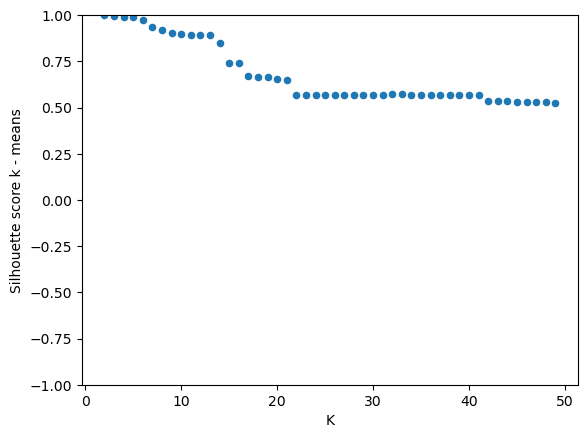

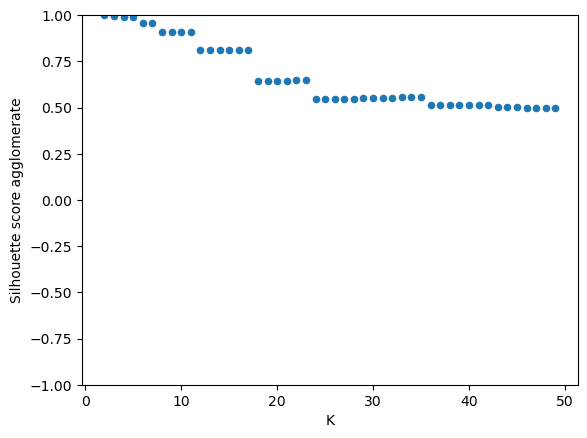

In [16]:
k_mean, agglom = cluster_algo(cleaned_sales)


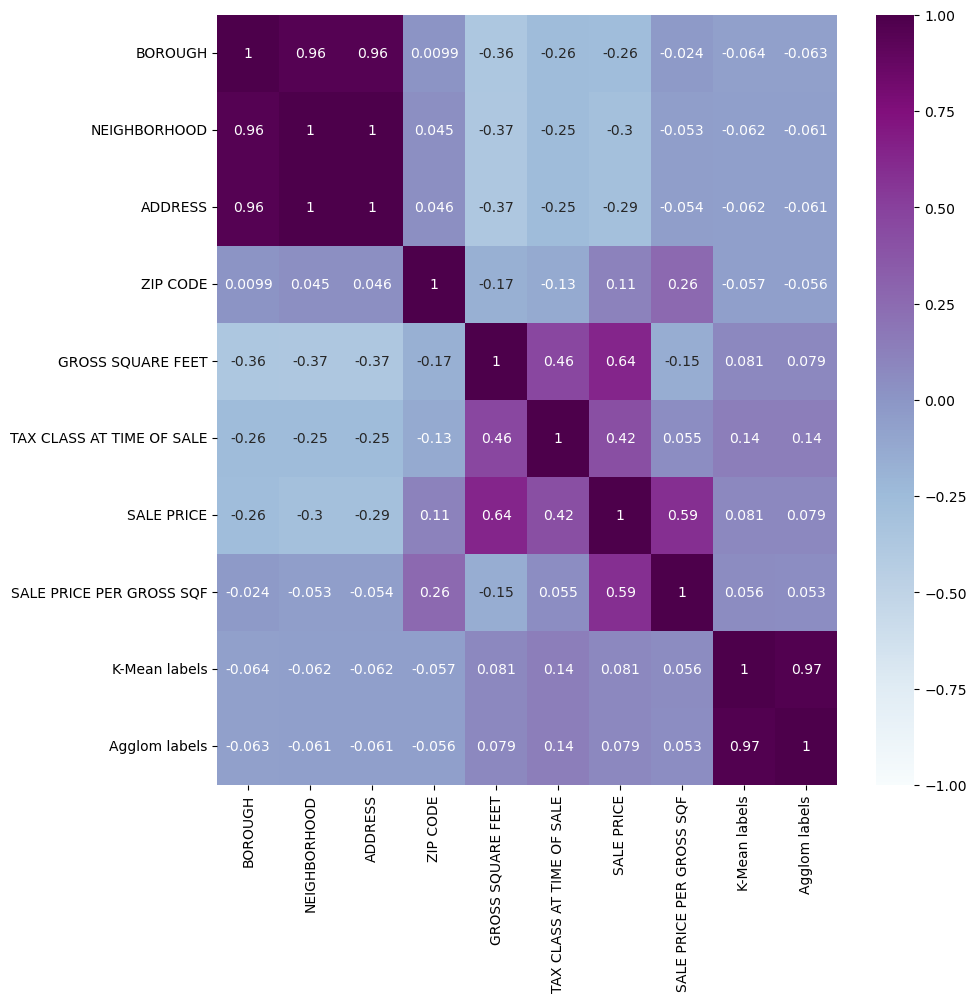

In [17]:
# Add labels to data frame
cleaned_sales["K-Mean labels"] = k_mean[3][1]
cleaned_sales["Agglom labels"] = agglom[3][1]

cluster_sales = cleaned_sales.copy()

# Save new clustred data frame
filepath = Path('csv_files/cluster_sales.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
cluster_sales.to_csv(filepath, index=False)

# Plot heat map with respect to labels to analyze what the labels have been clusterd by
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cluster_sales.corr('spearman'), vmin=-1,
            vmax=1, cmap="BuPu", annot=True, ax=ax)

plt.show()


In [18]:
def add_name(row):
    if row['BOROUGH'] == 1:
        return 'manhattan'
    elif row["BOROUGH"] == 2:
        return "Bronx"
    elif row["BOROUGH"] == 3:
        return "Brooklyn"
    elif row["BOROUGH"] == 4:
        return "Queens"
    else:
        return 'State Island'


cluster_sales['BOROUGH NAME'] = cluster_sales.apply(add_name, axis=1)

fig = px.box(cluster_sales, y="SALE PRICE PER GROSS SQF",
             x="BOROUGH NAME", width=800, height=400)

fig.show()

# We don't need the column BOROUGH NAME anymore, so we drop it
cluster_sales = cluster_sales.drop(columns='BOROUGH NAME')


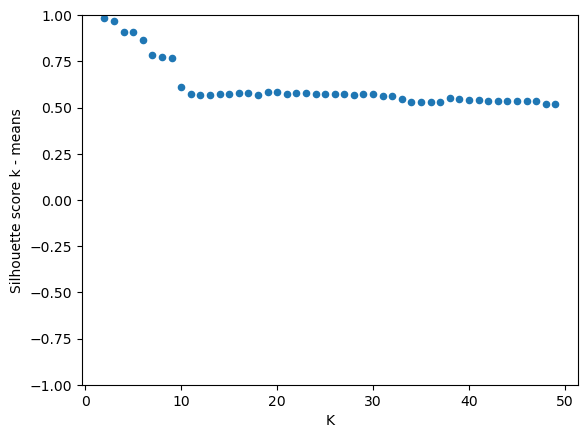

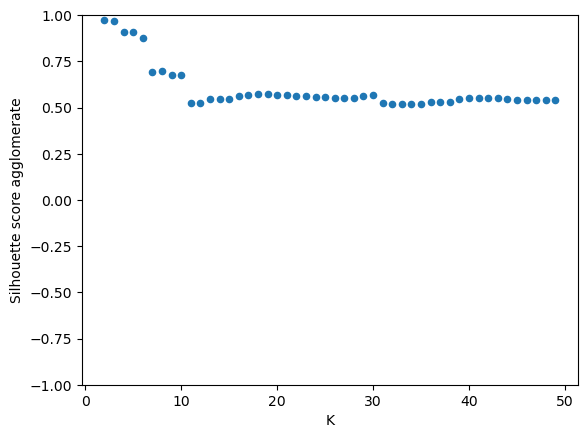

In [19]:
# Filter only by one borough (Manhattan) as outlined by the report
manhattan_sale = cleaned_sales[cleaned_sales["BOROUGH"] == 1]
k_mean, agglom = cluster_algo(manhattan_sale)


/var/folders/bm/1907kxqs14v6sfj1kdxgyy8c0000gn/T/ipykernel_19006/125485109.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bm/1907kxqs14v6sfj1kdxgyy8c0000gn/T/ipykernel_19006/125485109.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



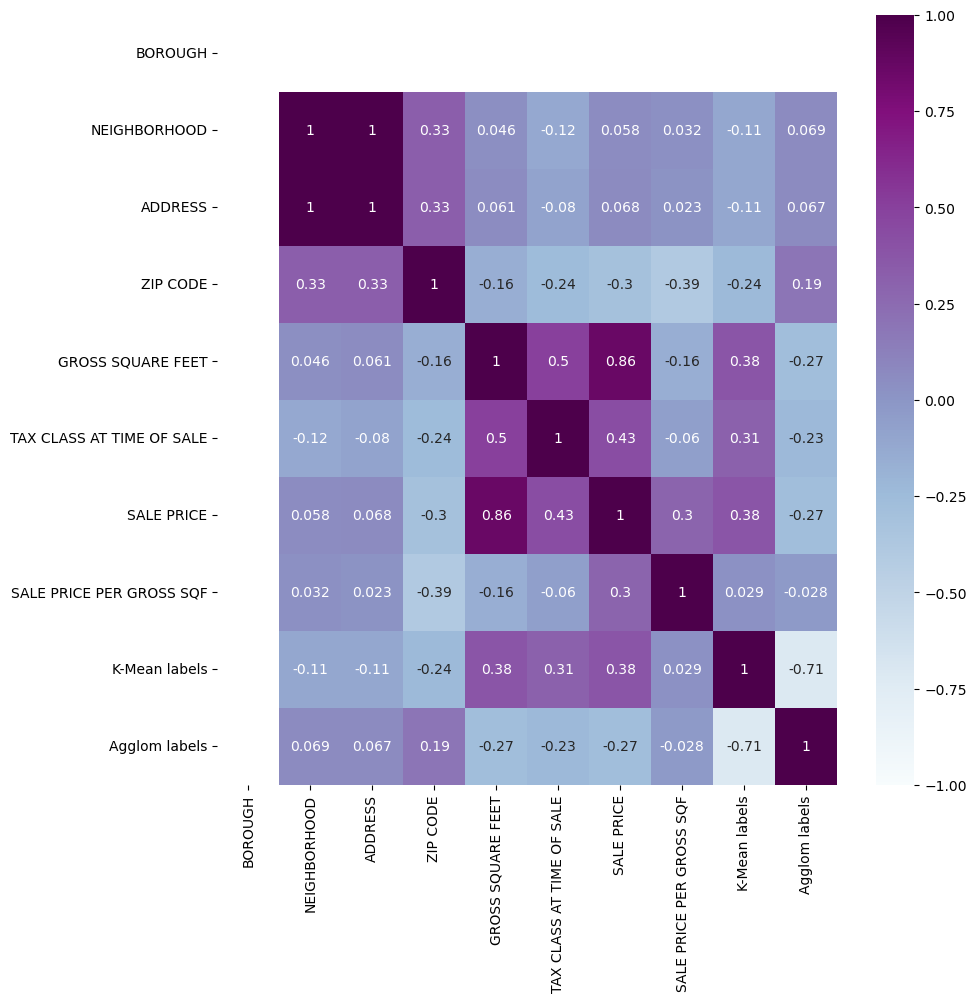

In [20]:
# Add labels to data frame
manhattan_sale["K-Mean labels"] = k_mean[3][1]
manhattan_sale["Agglom labels"] = agglom[3][1]

cluster_manhattan_sales = manhattan_sale.copy()

# Save new clustred data frame
filepath = Path('csv_files/cluster_manhattan_sales.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
cluster_manhattan_sales.to_csv(filepath, index=False)

# Plot heat map with respect to labels to analyze what the labels have been clusterd by
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cluster_manhattan_sales.corr('spearman'), vmin=-1,
            vmax=1, cmap="BuPu", annot=True, ax=ax)

plt.show()


## PCA (reduce dimensionality) on data frame "Cluster Sales" with two componens
source used: https://builtin.com/data-science/tsne-python

In [21]:
# Principle component analysis with n = 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_sales.values)

cluster_sales['pca-one'] = pca_result[:, 0]
cluster_sales['pca-two'] = pca_result[:, 1]


In [22]:
cluster_sales.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24026 entries, 0 to 84546
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    24026 non-null  int64  
 1   NEIGHBORHOOD               24026 non-null  int64  
 2   ADDRESS                    24026 non-null  int64  
 3   ZIP CODE                   24026 non-null  int64  
 4   GROSS SQUARE FEET          24026 non-null  int64  
 5   TAX CLASS AT TIME OF SALE  24026 non-null  int64  
 6   SALE PRICE                 24026 non-null  int64  
 7   SALE PRICE PER GROSS SQF   24026 non-null  float64
 8   K-Mean labels              24026 non-null  int32  
 9   Agglom labels              24026 non-null  int64  
 10  pca-one                    24026 non-null  float64
 11  pca-two                    24026 non-null  float64
dtypes: float64(3), int32(1), int64(8)
memory usage: 2.3 MB


# Visualization of PCA components

/var/folders/bm/1907kxqs14v6sfj1kdxgyy8c0000gn/T/ipykernel_19006/1714028672.py:4: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.

/var/folders/bm/1907kxqs14v6sfj1kdxgyy8c0000gn/T/ipykernel_19006/1714028672.py:21: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.

/var/folders/bm/1907kxqs14v6sfj1kdxgyy8c0000gn/T/ipykernel_19006/1714028672.py:38: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



(-463761081.3116053, 2318805406.5580263)

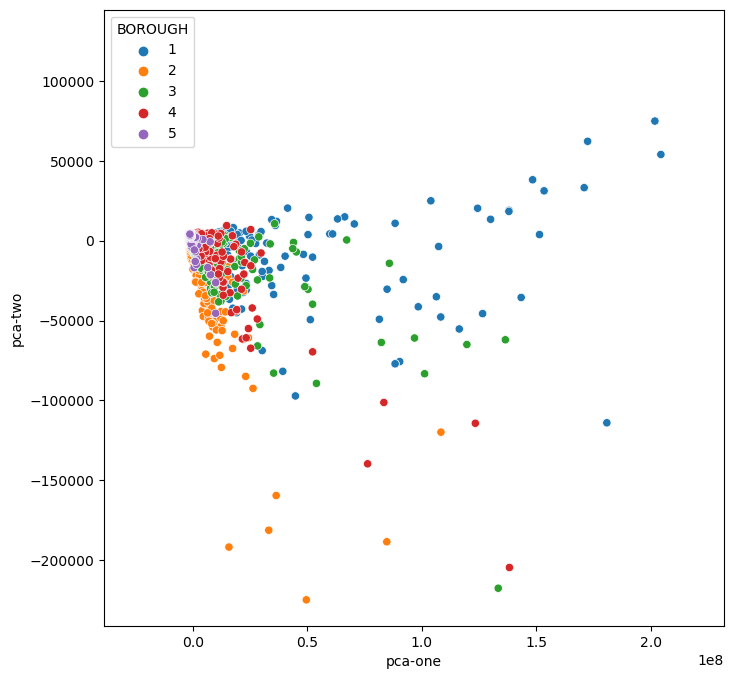

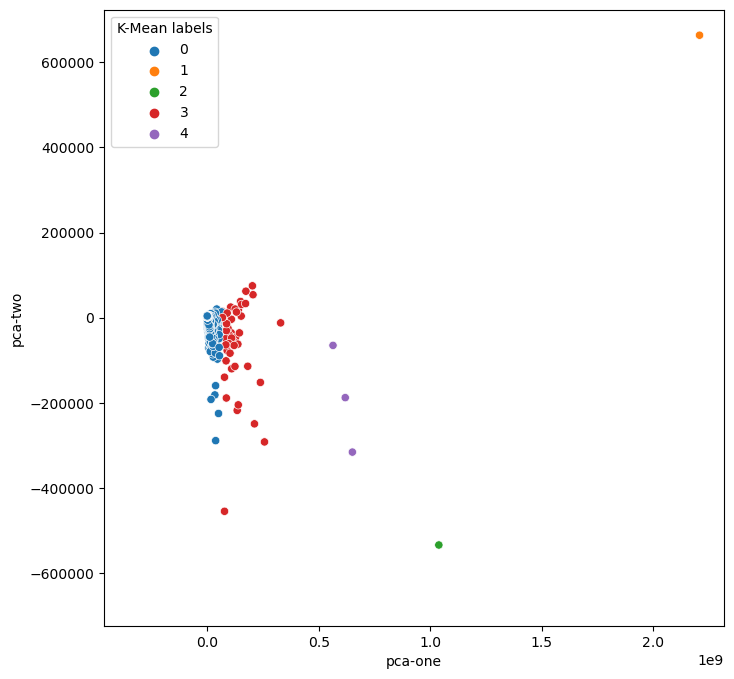

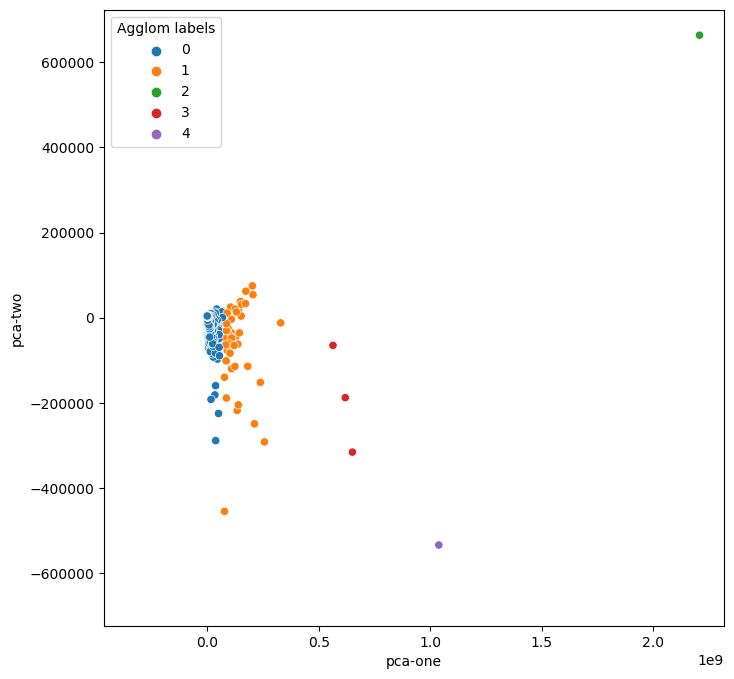

In [23]:

# VISUALIZATION BY BOROUGH
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=cluster_sales,
                x='pca-one', y='pca-two',
                hue="BOROUGH",
                palette=sns.color_palette("tab10"),
                legend="full",
                ax=ax,
                )

yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max/3, ymax=yabs_max/5)
xabs_max = abs(max(ax.get_xlim(), key=abs))
ax.set_xlim(xmin=-xabs_max/60, xmax=xabs_max/10)


# VISUALIZATION BY K-MEANS LABELS AT k= 5
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=cluster_sales,
                x='pca-one', y='pca-two',
                hue="K-Mean labels",
                palette=sns.color_palette("tab10"),
                legend="full",
                ax=ax,
                )

yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
xabs_max = abs(max(ax.get_xlim(), key=abs))
ax.set_xlim(xmin=-xabs_max/5, xmax=xabs_max)


# VISUALIZATION BY AGGLOMERATIVE LABELS AT k= 5
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=cluster_sales,
                x='pca-one', y='pca-two',
                hue="Agglom labels",
                palette=sns.color_palette("tab10"),
                legend="full",
                ax=ax,
                )

yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
xabs_max = abs(max(ax.get_xlim(), key=abs))
ax.set_xlim(xmin=-xabs_max/5, xmax=xabs_max)


In [24]:
k_mean_df = cluster_sales[['K-Mean labels', 'pca-one']]
k_mean_df = k_mean_df.rename(
    columns={"pca-one": "Count entities by K-Mean labels"})
k_mean_df = k_mean_df.groupby(
    'K-Mean labels').count().reset_index()
k_mean_df


,K-Mean labels,Count entities by K-Mean labels
0,0,23973
1,1,1
2,2,1
3,3,48
4,4,3


In [25]:
k_mean_sum = k_mean_df['Count entities by K-Mean labels'].sum()
k_mean_sum


24026

In [26]:
agglom_df = cluster_sales[['Agglom labels', 'pca-one']]
agglom_df = agglom_df.rename(
    columns={"pca-one": "Count entities by Agglom labels"})
agglom_df = agglom_df.groupby(
    'Agglom labels').count().reset_index()
agglom_df


,Agglom labels,Count entities by Agglom labels
0,0,23976
1,1,45
2,2,1
3,3,3
4,4,1


In [27]:
agglom_sum = agglom_df['Count entities by Agglom labels'].sum()
agglom_sum


24026

## PCA (reduce dimensionality) on data frame "Manhattan Cluster Sales" with two componens

In [28]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_manhattan_sales.values)

cluster_manhattan_sales['pca-one'] = pca_result[:, 0]
cluster_manhattan_sales['pca-two'] = pca_result[:, 1]


In [29]:
cluster_manhattan_sales.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 18300
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    682 non-null    int64  
 1   NEIGHBORHOOD               682 non-null    int64  
 2   ADDRESS                    682 non-null    int64  
 3   ZIP CODE                   682 non-null    int64  
 4   GROSS SQUARE FEET          682 non-null    int64  
 5   TAX CLASS AT TIME OF SALE  682 non-null    int64  
 6   SALE PRICE                 682 non-null    int64  
 7   SALE PRICE PER GROSS SQF   682 non-null    float64
 8   K-Mean labels              682 non-null    int32  
 9   Agglom labels              682 non-null    int64  
 10  pca-one                    682 non-null    float64
 11  pca-two                    682 non-null    float64
dtypes: float64(3), int32(1), int64(8)
memory usage: 66.6 KB


# Visualization of PCA components

/var/folders/bm/1907kxqs14v6sfj1kdxgyy8c0000gn/T/ipykernel_19006/94593067.py:4: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.

/var/folders/bm/1907kxqs14v6sfj1kdxgyy8c0000gn/T/ipykernel_19006/94593067.py:22: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



(-459609921.8120985, 2298049609.0604925)

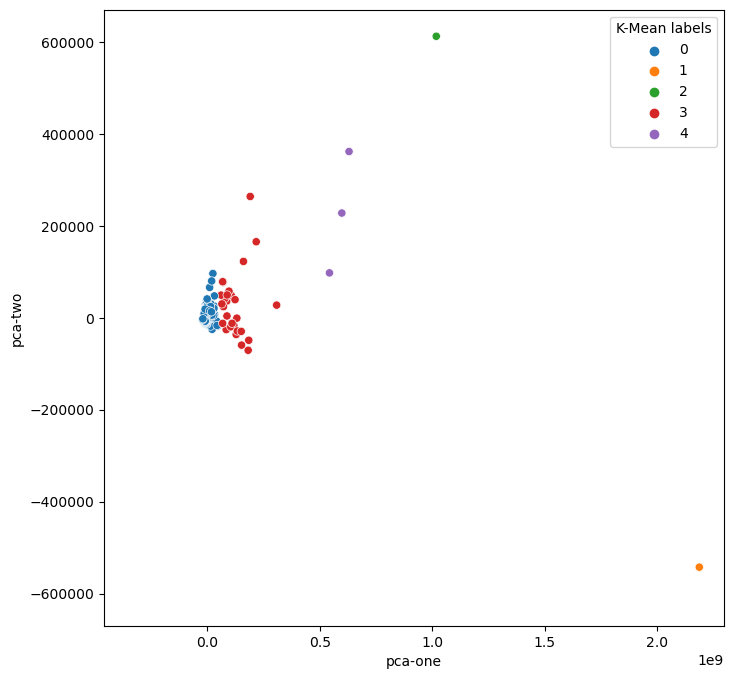

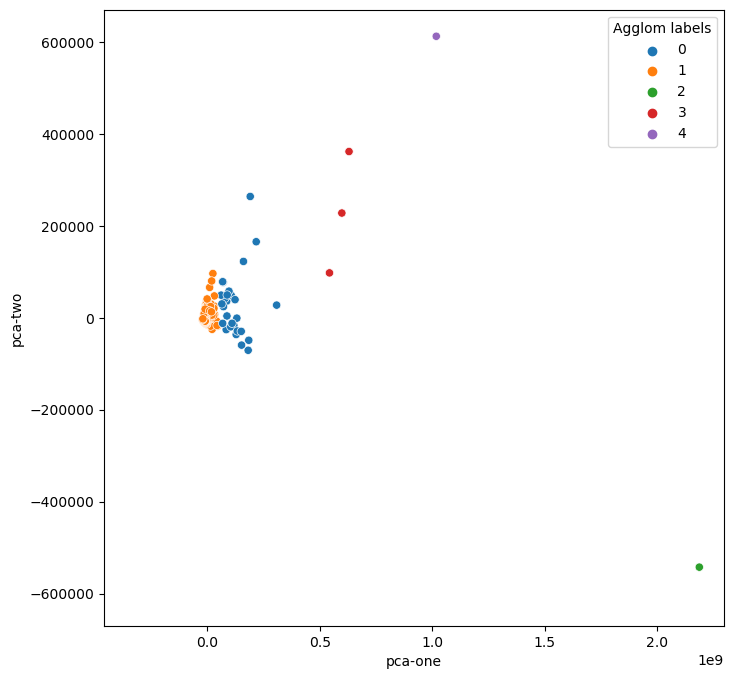

In [30]:
# VISUALIZATION BY K-MEANS LABELS AT k= 5
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=cluster_manhattan_sales,
                x='pca-one', y='pca-two',
                hue="K-Mean labels",
                palette=sns.color_palette("tab10"),
                legend="full",
                ax=ax,
                )


yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
xabs_max = abs(max(ax.get_xlim(), key=abs))
ax.set_xlim(xmin=-xabs_max/5, xmax=xabs_max)


# VISUALIZATION BY AGGLOM LABELS AT k= 5
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=cluster_manhattan_sales,
                x='pca-one', y='pca-two',
                hue="Agglom labels",
                palette=sns.color_palette("tab10"),
                legend="full",
                ax=ax,
                )


yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
xabs_max = abs(max(ax.get_xlim(), key=abs))
ax.set_xlim(xmin=-xabs_max/5, xmax=xabs_max)


In [31]:
k_mean_manhattan_df = cluster_manhattan_sales[['K-Mean labels', 'BOROUGH']]
k_mean_manhattan_df = k_mean_manhattan_df.rename(
    columns={"BOROUGH": "Count entities by K-Mean labels"})
k_mean_manhattan_df = k_mean_manhattan_df.groupby(
    'K-Mean labels').count().reset_index()
k_mean_manhattan_df


,K-Mean labels,Count entities by K-Mean labels
0,0,647
1,1,1
2,2,1
3,3,30
4,4,3


In [32]:
k_mean_sum = k_mean_manhattan_df['Count entities by K-Mean labels'].sum()
k_mean_sum

682

In [33]:
agglom_labels_manhattan_df = cluster_manhattan_sales[[
    'Agglom labels', 'BOROUGH']]
agglom_labels_manhattan_df = agglom_labels_manhattan_df.rename(
    columns={"BOROUGH": "Count entities by Agglom labels"})
agglom_labels_manhattan_df = agglom_labels_manhattan_df.groupby(
    'Agglom labels').count().reset_index()
agglom_labels_manhattan_df


,Agglom labels,Count entities by Agglom labels
0,0,30
1,1,647
2,2,1
3,3,3
4,4,1


In [34]:
agglom_sum = agglom_labels_manhattan_df['Count entities by Agglom labels'].sum()
agglom_sum


682

## CLUSTERING ALGORITHM 2 - SPECTRAL CLUSTERING

In [35]:
def spectral_clustering(data, cl_range=[2, 50]):

    labels_spectral = []
    silhouette_score_spec = []
    k_values = []

    for i in range(cl_range[0], cl_range[1]):
        # print("now in ", i)
        model = SpectralClustering(
            n_clusters=i, affinity='nearest_neighbors', assign_labels='kmeans')
        labels = model.fit_predict(data)
        labels_spectral.append((i, labels))
        score = silhouette_score(data, labels)
        silhouette_score_spec.append(score)
        k_values.append(i)

    df = pd.DataFrame(
        {"K": k_values, "Spectral Clustering": silhouette_score_spec})

    df.plot(x='K', y="Spectral Clustering", kind='scatter', ylim=(-1, 1))
    plt.show()

    return silhouette_score_spec, labels_spectral


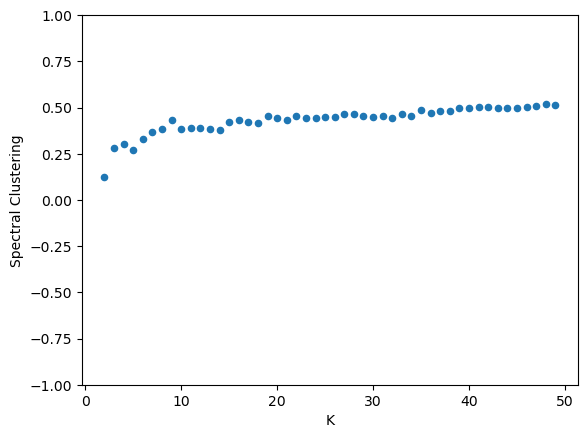

In [36]:
# Execute spectral clustering
_, label = spectral_clustering(cluster_manhattan_sales)

# Add labels of spectral clustering with k = 5 to the data frame
cluster_manhattan_sales["Spectral_Clustering"] = label[3][1]


In [37]:
cluster_manhattan_sales.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 18300
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    682 non-null    int64  
 1   NEIGHBORHOOD               682 non-null    int64  
 2   ADDRESS                    682 non-null    int64  
 3   ZIP CODE                   682 non-null    int64  
 4   GROSS SQUARE FEET          682 non-null    int64  
 5   TAX CLASS AT TIME OF SALE  682 non-null    int64  
 6   SALE PRICE                 682 non-null    int64  
 7   SALE PRICE PER GROSS SQF   682 non-null    float64
 8   K-Mean labels              682 non-null    int32  
 9   Agglom labels              682 non-null    int64  
 10  pca-one                    682 non-null    float64
 11  pca-two                    682 non-null    float64
 12  Spectral_Clustering        682 non-null    int32  
dtypes: float64(3), int32(2), int64(8)
memory usage: 

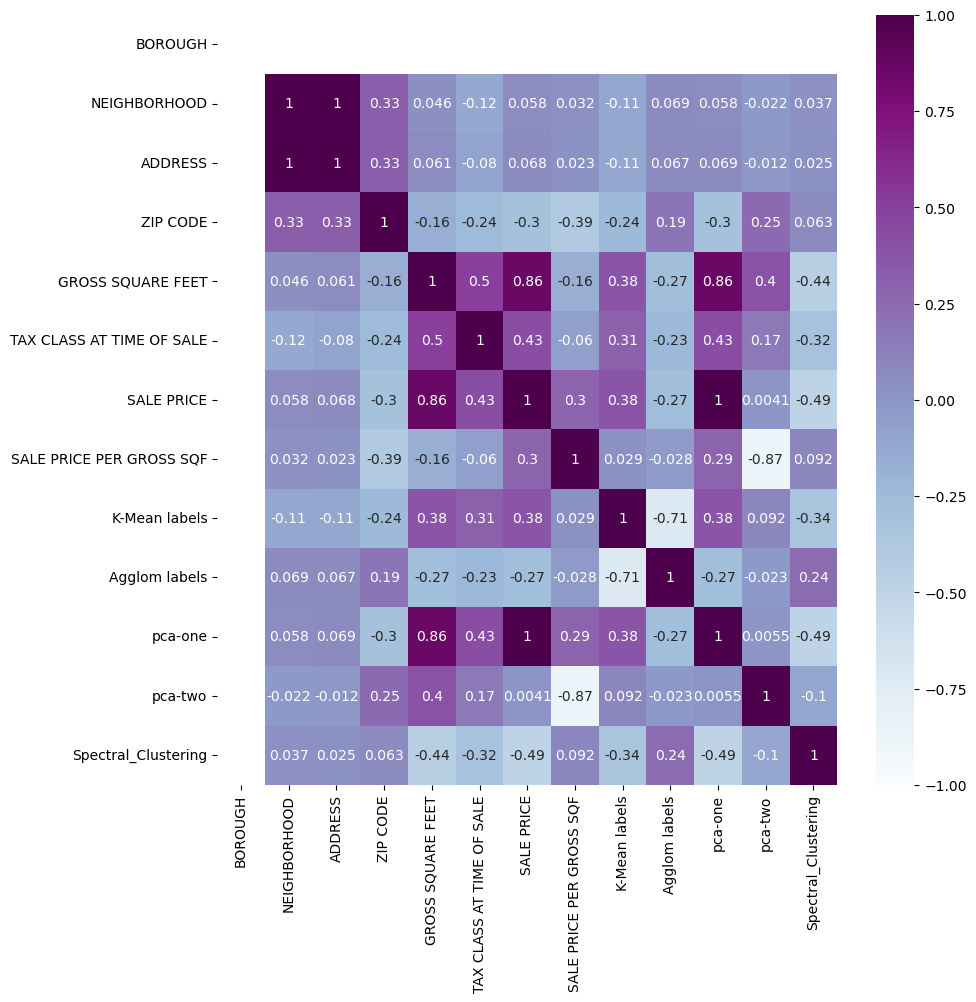

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cluster_manhattan_sales.corr('spearman'), vmin=-1,
            vmax=1, cmap="BuPu", annot=True, ax=ax)

plt.show()


/var/folders/bm/1907kxqs14v6sfj1kdxgyy8c0000gn/T/ipykernel_19006/743073195.py:3: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



(-45960992.18120985, 45960992.18120985)

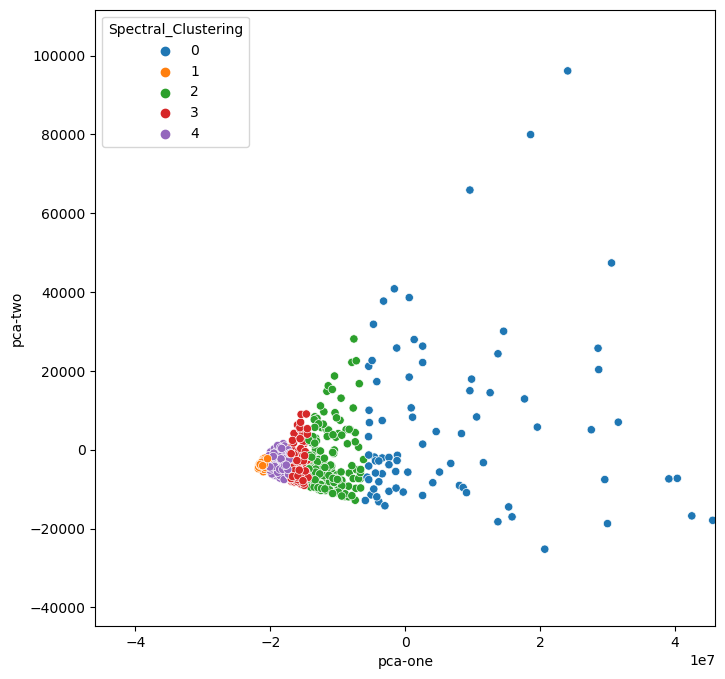

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=cluster_manhattan_sales,
                x='pca-one', y='pca-two',
                hue='Spectral_Clustering',
                palette=sns.color_palette("tab10"),
                legend="full",
                ax=ax,
                )


yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max/15, ymax=yabs_max/6)
xabs_max = abs(max(ax.get_xlim(), key=abs))
ax.set_xlim(xmin=-xabs_max/50, xmax=xabs_max/50)


In [40]:
spectral_manhattan_df = cluster_manhattan_sales[[
    'Spectral_Clustering', 'BOROUGH']]
spectral_manhattan_df = spectral_manhattan_df.rename(
    columns={"BOROUGH": "Count entities by Spectral Clustering"})
spectral_manhattan_df = spectral_manhattan_df.groupby(
    'Spectral_Clustering').count().reset_index()
spectral_manhattan_df
spectral_manhattan_df


,Spectral_Clustering,Count entities by Spectral Clustering
0,0,117
1,1,94
2,2,159
3,3,144
4,4,168


In [41]:
spectral_sum = spectral_manhattan_df['Count entities by Spectral Clustering'].sum()
spectral_sum


682